### 修复IndexError


Analyzing word: carte


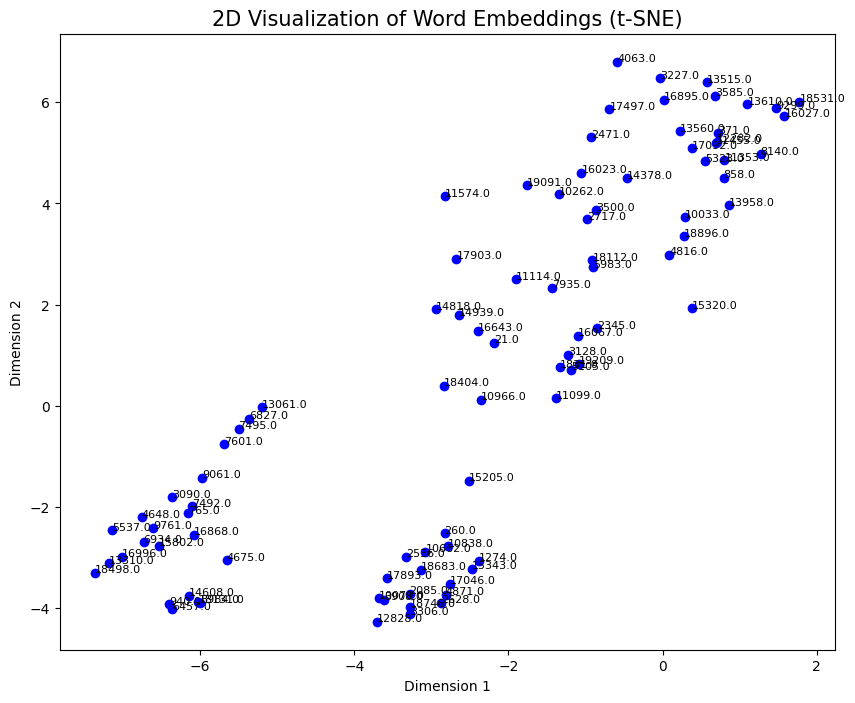


Word: carte
Occurrences: 91
Polysemy score: 0.2017
Review ID 13515.0: [-0.09739526  0.22611952 -0.06554797  0.00891011  0.06077262]...
Review ID 9299.0: [-0.02040839  0.43099886 -0.25826508  0.08422412  0.0658479 ]...
Review ID 11114.0: [-0.09424193  0.14339781 -0.16163269  0.00625283  0.05057091]...
Review ID 10079.0: [ 0.00566061  0.09188987 -0.02428986  0.19286166 -0.08358805]...
Review ID 15802.0: [-0.03029492  0.19962448 -0.15159762  0.26079425 -0.00361181]...
Review ID 3227.0: [ 0.00512006  0.38953453 -0.3304835  -0.02280198  0.09513839]...
Review ID 13061.0: [-0.01035636  0.20890889 -0.12677434  0.24788027 -0.00534561]...
Review ID 12828.0: [ 0.03277437  0.06720001 -0.10885408  0.1908938  -0.01830762]...
Review ID 18131.0: [ 0.00907368  0.27355686 -0.03525553  0.23288327 -0.00487238]...
Review ID 2085.0: [-0.01689576  0.16293874 -0.05530068  0.15094993  0.03283637]...
Review ID 12282.0: [-0.02872918  0.42914852 -0.11634512 -0.05765582  0.07907728]...
Review ID 1274.0: [-0.09512

In [3]:
import pandas as pd
import torch
from transformers import CamembertTokenizer, CamembertModel
import numpy as np
import re
import spacy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 加载法语模型
nlp = spacy.load("fr_core_news_sm")

def lemmatize_text(text):
    """使用spaCy进行词形还原"""
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def preprocess_and_embed(texts, ids, word, tokenizer, model, batch_size=8):
    """预处理文本并获取目标词嵌入"""
    word_embeddings = []
    review_embeddings = []
    matched_ids = []  # 新增：保存成功匹配的ID

    # 对批次进行编码
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_ids = ids[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

        # 获取每个句子中目标词的位置
        word_ids = [next((i+1 for i, token in enumerate(tokenizer.tokenize(text)) if word in token), None) for text in batch_texts]

        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.last_hidden_state

            # 提取目标词的embeddings并记录索引
            for idx, word_id in enumerate(word_ids):
                if word_id is not None:
                    word_embeddings.append(hidden_states[idx, word_id].numpy())
                    review_embeddings.append({'id': batch_ids[idx], 'embedding': hidden_states[idx, word_id].numpy()})
                    matched_ids.append(batch_ids[idx])  # 新增：保存匹配的ID

    return word_embeddings, review_embeddings, matched_ids  # 修改：返回matched_ids

def visualize_embeddings(word_embeddings, review_ids):
    """使用t-SNE可视化目标词的二维嵌入"""
    word_embeddings_array = np.array(word_embeddings)

    # 检查样本数量，并调整perplexity
    n_samples = len(word_embeddings_array)
    if n_samples < 2:
        print("Not enough samples for visualization")
        return

    perplexity_value = min(30, n_samples - 1)

    # 使用t-SNE降维
    tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
    reduced_embeddings = tsne.fit_transform(word_embeddings_array)

    # 绘制二维散点图
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', marker='o')

    # 确保review_ids长度与reduced_embeddings相同
    assert len(review_ids) == len(reduced_embeddings), "Mismatch between review_ids and embeddings"

    # 显示id标签
    for i, review_id in enumerate(review_ids):
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], str(review_id), fontsize=8)

    plt.title("2D Visualization of Word Embeddings (t-SNE)", fontsize=15)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

def analyze_word(word, df, sample_size=100):
    """分析单个词的多义性"""
    tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
    model = CamembertModel.from_pretrained('camembert-base')
    model.eval()

    relevant_texts = df[df['review'].str.contains(word, case=False, na=False, regex=False)]
    if relevant_texts.empty:
        print(f"No occurrences found for word: {word}")
        return None

    relevant_texts = relevant_texts.sample(n=min(len(relevant_texts), sample_size), random_state=42)

    # 获取对应的id和预处理文本
    ids = relevant_texts.iloc[:, 0].values
    processed_texts = [lemmatize_text(re.sub(r'[^\w\s]', ' ', str(text).lower()).strip()) for text in relevant_texts['review']]

    word_embeddings, review_embeddings, matched_ids = preprocess_and_embed(processed_texts, ids, word, tokenizer, model)  # 修改：接收matched_ids

    if len(word_embeddings) < 2:
        print(f"Not enough valid embeddings found for word: {word}")
        return None

    # 计算余弦相似度矩阵并得到多义性分数
    embeddings_array = np.array(word_embeddings)
    norm = np.linalg.norm(embeddings_array, axis=1, keepdims=True)
    similarity_matrix = np.dot(embeddings_array / norm, (embeddings_array / norm).T)

    polysemy_score = np.std(similarity_matrix[np.triu_indices(len(similarity_matrix), k=1)])

    # 使用匹配的ID进行可视化
    visualize_embeddings(word_embeddings, matched_ids)

    return {
        'word': word,
        'occurrences': len(word_embeddings),
        'polysemy_score': polysemy_score,
        'review_embeddings': review_embeddings
    }

def quick_polysemy_analysis(file_path, target_words, sample_size=100):
    """主分析函数"""
    df = pd.read_csv(file_path, header=None, names=['id', 'film-url', 'review', 'polarity'])

    results = []
    for word in target_words:
        print(f"\nAnalyzing word: {word}")
        analysis_result = analyze_word(word, df, sample_size)
        if analysis_result:
            results.append(analysis_result)

    for result in results:
        print(f"\nWord: {result['word']}")
        print(f"Occurrences: {result['occurrences']}")
        print(f"Polysemy score: {result['polysemy_score']:.4f}")

        # 输出每个review的目标词嵌入及其对应的id
        for review in result['review_embeddings']:
            print(f"Review ID {review['id']}: {review['embedding'][:5]}...")  # 显示嵌入的前5个数值，避免输出过长

    return results

# 使用示例
file_path = 'test.csv'
target_words = ['carte']
results = quick_polysemy_analysis(file_path, target_words, sample_size=100)
